# Hopfield - New energy function for continuous-valued patterns and states
So far, we have explored the standard Hopfield networks and an improved version that helps distinguish between correlated patterns. But still, it only works with polar patterns, i.e., $x_i \in \{1, -1\}^d$. In this notebook, the implementation abstracts to continuous values patterns.

References:
* https://ml-jku.github.io/hopfield-layers/
* [Hopfield Networks is All you Need](https://arxiv.org/abs/2008.02217)

## New energy function
The new Energy Function proposed to contemplate continuous-valued patterns is as follows:

$$
E = - \mathrm{lse}(\beta, X^T\xi) + \frac{1}{2}\xi^T\xi+\beta^{-1}\mathrm{log}N+\frac{1}{2}M^2
$$

where $N$ is the number of **continuous** stored patterns by matrix $X$, and $M$ is the largest norm of all stored patterns.

## New update rule
The new updated rule derived from the new energy function is as follows:
$$
\xi^{new} = X\mathrm{softmax}(\beta X^T \xi)
$$

With above modifications, we proceed to the implementation as follows:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from skimage.transform import resize

width, height = 128, 128

def load_images(im_ids):
    imgs = [image.imread(f'subset_gray/{id}') for id in im_ids]
    imgs = [resize(img, (width, height)) for img in imgs]
    fig, ax = plt.subplots(1, len(imgs), figsize=(16, 6))
    axes = ax.ravel()
    fig.suptitle("Stored patterns ")
    for idx in range(len(imgs)):
        axes[idx].imshow(imgs[idx], cmap='gray')
    plt.show()
    return imgs

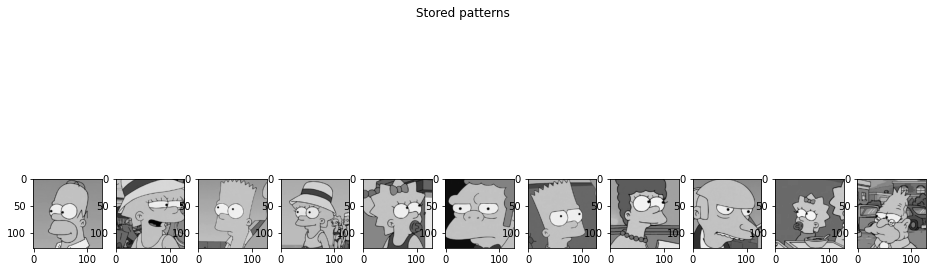

In [7]:
im_ids = ['13.png', '8.png', '28.png', '16.png', '18.png', '50.png', '67.png', '83.png', '203.png', '345.png', '953.png']
set1 = load_images(im_ids)

In [10]:
from scipy.special import logsumexp

def energy(X, state, b = 1e-3):
    """New energy function as per
    Hofield networks is all you need."""
    N = X.shape[1]
    M = np.max(np.apply_along_axis(np.linalg.norm, 1, X))
    return -logsumexp(b, X.T @ state) + 0.5 * state.T @ state + (b ** -1) * np.log(N) + 0.5 * M ** 2

In [17]:
from scipy.special import softmax

def retrieve_pattern(et, X, b: float = 1.0, steps: int = 200):
    energy_old = np.infty
    energy_new = energy(X, et, b)
    iteration = 0

    while (energy_old > energy_new) and iteration < steps:
        iteration += 1
        energy_old = energy_new
        et = X * softmax(b * X.T @ et)
        energy_new = energy(X, et, b)
    
    print(f"Stopped at iteration {iteration}")
    return et


In [18]:
def plot_retrieval(e0, et):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax = axes.ravel()
    ax[0].imshow(e0.reshape(width, height), cmap='binary_r')
    ax[0].set_title('Initial state pattern')
    ax[1].imshow(et.reshape(width, height), cmap='binary_r')
    ax[1].set_title('Retrieved pattern')
    plt.show()


In [21]:
X = set1[0].flatten().reshape(-1, 1)

In [22]:
homer = set1[0].flatten()
retrieved = retrieve_pattern(homer.copy(), X)
plot_retrieval(homer, set1[0])

TypeError: only integer scalar arrays can be converted to a scalar index